In [1]:
!pip install wfdb
!pip install neurokit2
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import wfdb
import mne
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from collections import Counter
import seaborn as sns
from tensorflow.keras import layers, losses
from sklearn.metrics import classification_report
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [6]:
st = ['/content/drive/MyDrive/ECG_full_st/s20481.csv', '/content/drive/MyDrive/ECG_full_st/s20461.csv']
ans = ['/content/drive/MyDrive/ECG_full_ans/s20481.csv', '/content/drive/MyDrive/ECG_full_ans/s20461.csv']

series_st = []
for file_path in st:
    if os.path.exists(file_path) and file_path.lower().endswith(".csv"):
        try:
            df = pd.read_csv(file_path)
            series_st.append(np.array(df.values.tolist()).reshape(-1))
        except pd.errors.EmptyDataError:
            continue

answer = []
for file_path in ans:
    if os.path.exists(file_path) and file_path.lower().endswith(".csv"):
        try:
            df = pd.read_csv(file_path)
            answer.append(np.array(df.values.tolist()).reshape(-1))
        except pd.errors.EmptyDataError:
            continue

In [7]:
X_train = series_st[0]
y_train = answer[0]

X_test = series_st[1]
y_test = answer[1]

In [9]:
def smooth_series(series):
    smoothed_series = []
    window_size = 5
    for i in range(0, len(series), window_size):
        window = series[i:i+window_size]
        smoothed_value = np.mean(window)
        smoothed_series.append(smoothed_value)
    return np.array(smoothed_series)

def smooth_ans_series(series):
    smoothed_series = []
    window_size = 5
    for i in range(0, len(series), window_size):
        window = series[i:i+window_size]
        if 1 in window or 2 in window:
          smoothed_series.append(1)
        else:
          smoothed_series.append(0)
    return np.array(smoothed_series)

def min_max_scaler(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def smooth_time_series(series, window_size):
    smoothed_series = np.convolve(series, np.ones(window_size)/window_size, mode='same')
    return smoothed_series

def get_data(X, y):
  time_series = smooth_time_series(min_max_scaler(smooth_series(X)), 5)
  ans = smooth_ans_series(y)
  # mean = time_series.mean(axis=0)
  # std = time_series.std(axis=0)
  # time_series = (time_series - mean) / std
  return time_series, ans

In [10]:
X_train_smooth, y_train_smooth = get_data(X_train, y_train)
X_test_smooth, y_test_smooth = get_data(X_test, y_test)

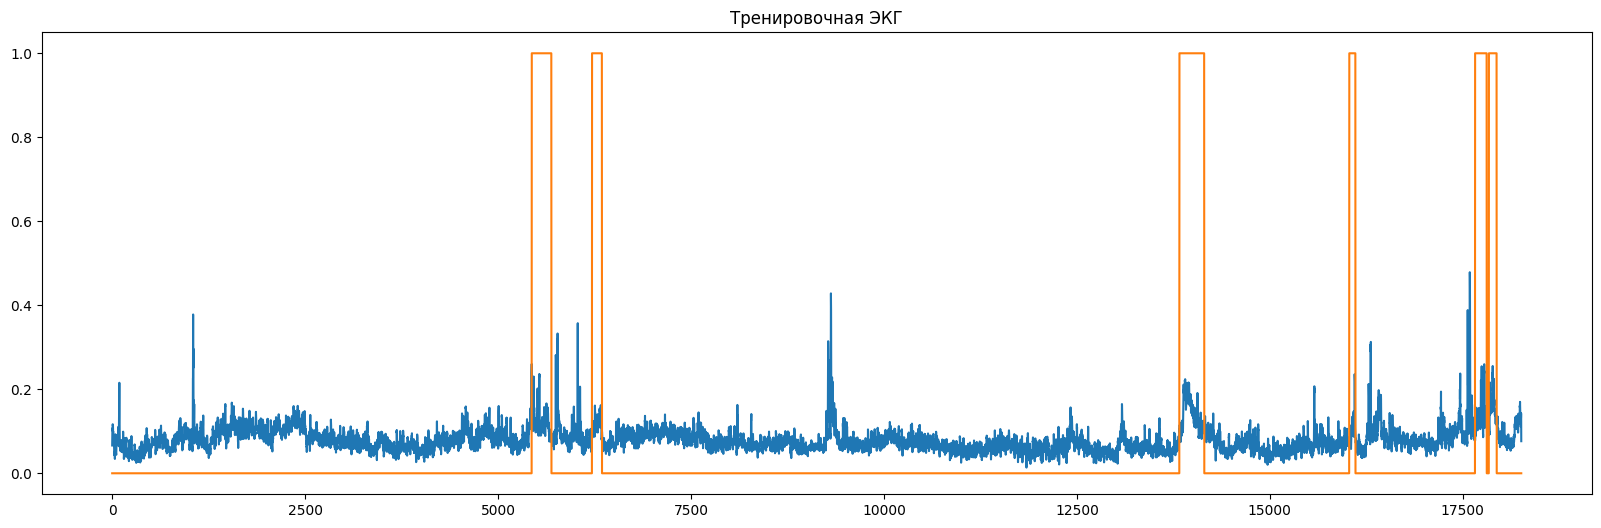

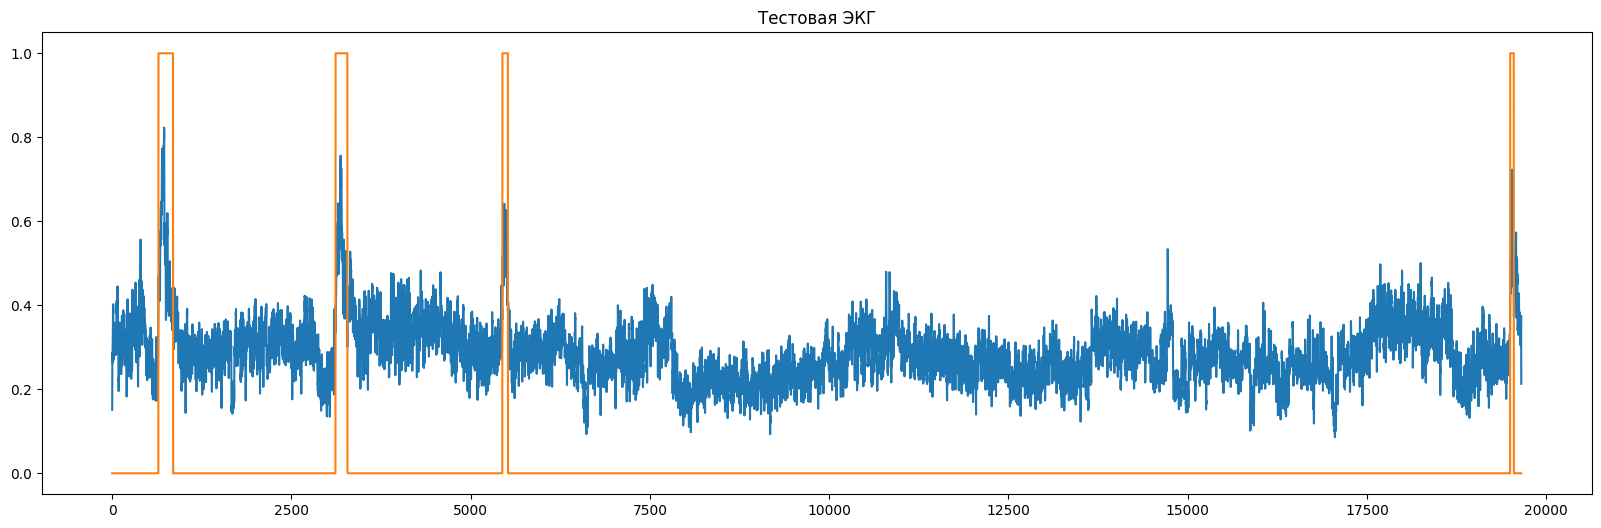

In [11]:
plt.figure(figsize=(20,6))
plt.plot(X_train_smooth)
plt.plot(y_train_smooth)
plt.title('Тренировочная ЭКГ')
plt.show()

plt.figure(figsize=(20,6))
plt.plot(X_test_smooth)
plt.plot(y_test_smooth)
plt.title('Тестовая ЭКГ')
plt.show()

In [12]:


# Вычисляем среднее значение
mean_value = np.mean(X_train_smooth)

# Вычитаем среднее из временного ряда
normalized_X_train = X_train_smooth - mean_value


In [13]:

# Вычисляем среднее значение
mean_value = np.mean(X_test_smooth)

# Вычитаем среднее из временного ряда
normalized_X_test = X_test_smooth - mean_value

In [15]:
a = np.where(np.array(y_train_smooth).astype(int) == 0)
X_train_normal = normalized_X_train[a]

In [16]:
def create_dataset(series, window_size):
    dataset = []
    for i in range(len(series) - window_size):
        dataset.append(series[i:i+window_size])
    return np.array(dataset)

window_size = 30
dataset = np.array(create_dataset(X_train_normal, window_size))
dataset.resize((dataset.shape[0], dataset.shape[1], 1))

In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(dataset.shape[1], dataset.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(rate=0.1))

model.add(RepeatVector(dataset.shape[1]))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(dataset.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 64)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           98816     
                                                        

In [20]:
history = model.fit(dataset, dataset, epochs=10, batch_size=32, validation_split = 0.1, verbose=1)

Epoch 1/10
484/484 [==============================] - 71s 128ms/step - loss: 0.0098 - val_loss: 0.0108
Epoch 2/10
484/484 [==============================] - 61s 125ms/step - loss: 0.0072 - val_loss: 0.0086
Epoch 3/10
484/484 [==============================] - 60s 123ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 4/10
484/484 [==============================] - 58s 121ms/step - loss: 0.0057 - val_loss: 0.0075
Epoch 5/10
484/484 [==============================] - 59s 121ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 6/10
484/484 [==============================] - 71s 148ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 7/10
484/484 [==============================] - 60s 124ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 8/10
484/484 [==============================] - 60s 123ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 9/10
484/484 [==============================] - 58s 121ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 10/10
484/484 [==============================] - 58s 120ms/step - l

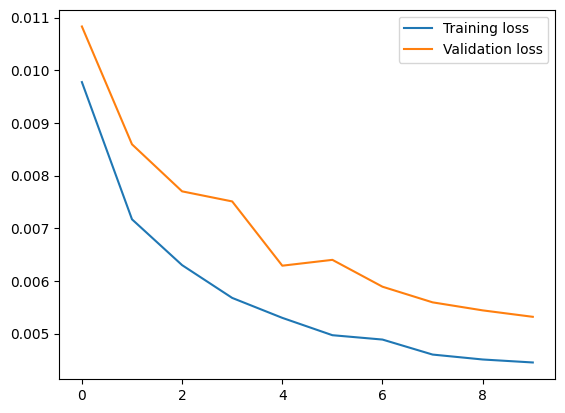

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

614/614 [==============================] - 27s 40ms/step


(array([5.140e+02, 5.408e+03, 7.875e+03, 4.025e+03, 1.162e+03, 2.590e+02,
        1.000e+02, 7.500e+01, 4.000e+01, 2.900e+01, 1.600e+01, 9.000e+00,
        6.000e+00, 1.000e+01, 8.000e+00, 1.100e+01, 9.000e+00, 8.000e+00,
        7.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 9.000e+00, 8.000e+00,
        4.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 0.000e+00, 4.000e+00]),
 array([0.00334895, 0.00632312, 0.00929728, 0.01227145, 0.01524561,
        0.01821977, 0.02119394, 0.0241681 , 0.02714226, 0.03011643,
        0.03309059, 0.03606476, 0.03903892, 0.04201308, 0.04498725,
        0.04796141, 0.05093558, 0.05390974, 0.0568839 , 0.05985807,
        0.06283223, 0.06580639, 0.06878056, 0.07175472, 0.07472889,
        0.07770305, 0.08067721, 0.08365138, 0.08662554, 0.08959971,
        0.09257387]),
 <BarContainer object of 30 artists>)

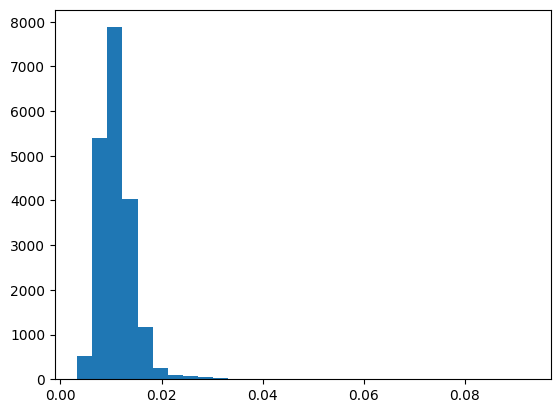

In [22]:
dataset_test = np.array(create_dataset(normalized_X_test, window_size))
dataset_test.resize((dataset_test.shape[0], dataset_test.shape[1], 1))

testPredict = model.predict(dataset_test)
testMAE = np.mean(np.abs(testPredict - dataset_test), axis=1)
plt.hist(testMAE, bins=30)

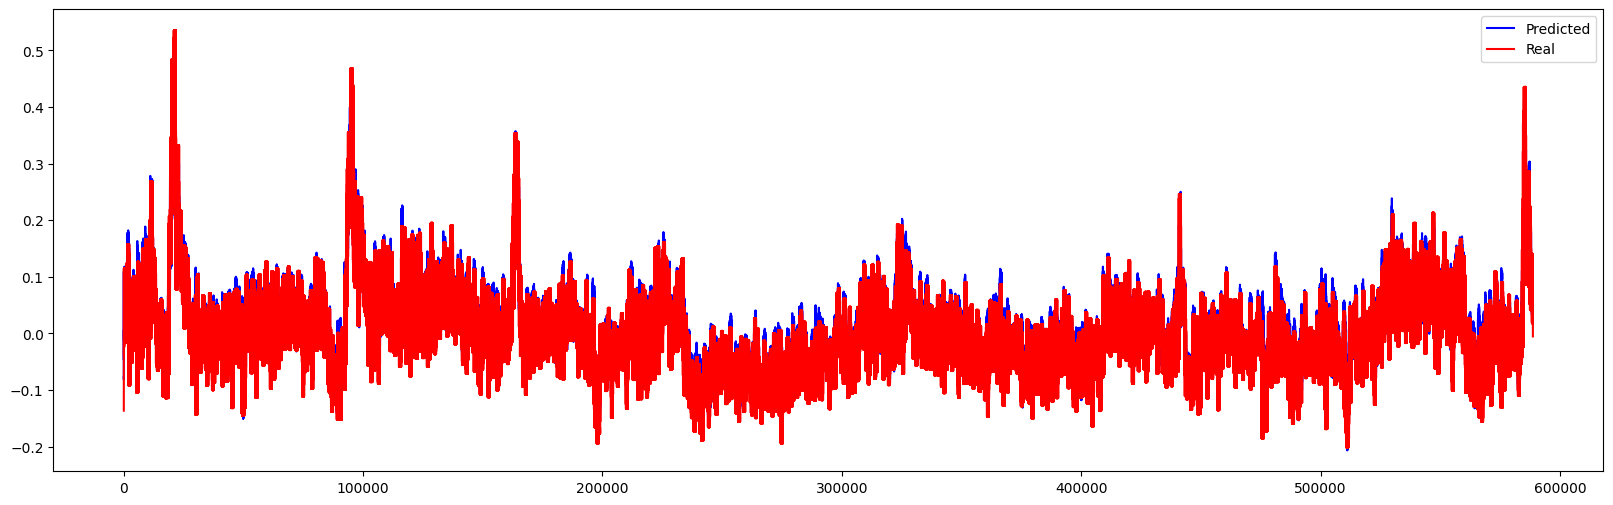

In [23]:
plt.figure(figsize=(20,6))
plt.plot(testPredict.flatten(), color='blue', label='Predicted')
plt.plot(dataset_test.flatten(), color='red', label='Real')
plt.legend()
plt.show()

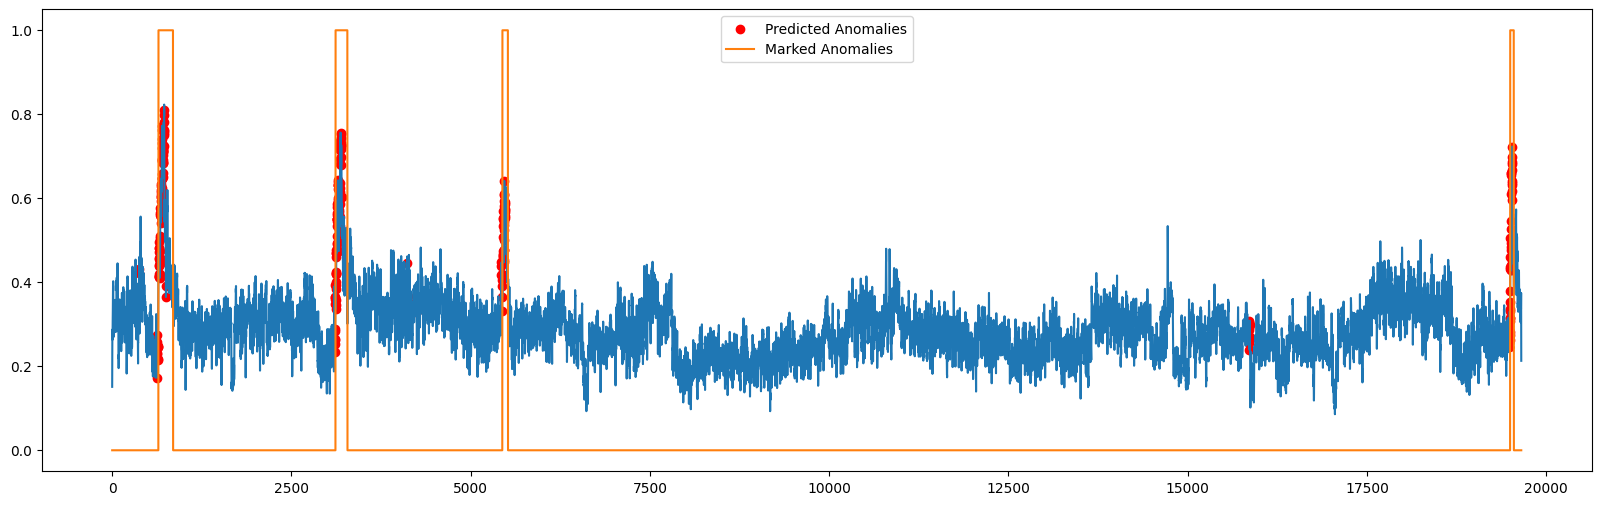

In [24]:
mae = np.mean(np.abs(testPredict - dataset_test), axis = 1)

treshold = np.median(mae) + 2.5 * np.std(mae)
anomalies = np.where(mae > treshold)[0]

plt.figure(figsize=(20,6))
plt.plot(X_test_smooth)

plt.scatter(anomalies, [X_test_smooth[i] for i in anomalies], color='red', label='Predicted Anomalies')
plt.plot([x for x in y_test_smooth], label = 'Marked Anomalies')
plt.legend()
plt.show()

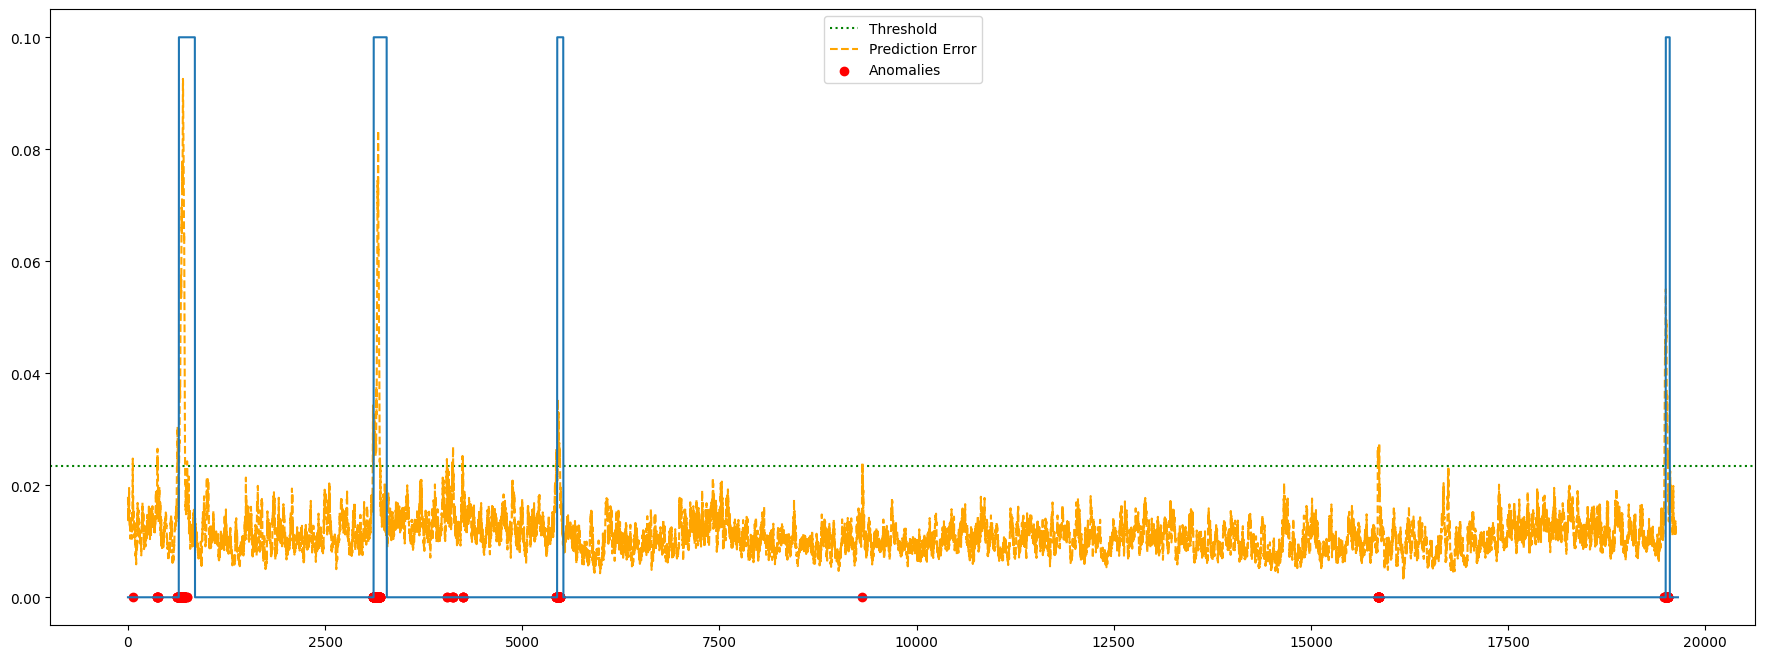

In [25]:
plt.figure(figsize=(22,8))


plt.axhline(y = treshold, color = 'green', linestyle=':', label = 'Threshold')
plt.plot(mae, label='Prediction Error', linestyle='--', color='orange')
plt.plot([x/10 for x in y_test_smooth])
plt.scatter(anomalies, [0 for i in range (len(anomalies))], color='red', label='Anomalies')

plt.legend()
plt.show()